### Generating bacth-corrected bulk data:

The codes in this notebook are based on, 
1) The codes by Cobos et al. (benchmark on deconvolution) with some modifications:
* Link to paper: https://www.nature.com/articles/s41467-020-19015-1 
* Link to Github: https://github.com/favilaco/deconv_benchmark

2) The codes by Sutton et al.
* Link to paper: https://www.nature.com/articles/s41467-022-28655-4
* Link to Github: https://github.com/Voineagulab/BrainCellularComposition

**Notes on Running the Notebook:**
1) Make sure that you have R installed before running this notebook.
2) The required libraries that need to be installed are listed in the cell below.

**Steps of Analysis performed in this Notebook:**
1) Load the real bulk data for non-affected and affected individuals
2) Load the preprocessed (QC+clustered) single cell data derived from one affected and one non-affected individual.
   Note that single cell RNA-seq was performed for three organoids per individual.
3) Generate the bulk samples per organoid by summing up the counts for the cells. 
   This generates three bulk samples per individual (total of six). We refer to this as "organoid bulk".
4) Per individual (affected and non-affected) generate bootstrapped bulk samples.
   Bootstrapping is done on the cells from 
   all organoids per individual. We refer to this as "bootstrapped bulk".

In [2]:
#install.packages("corrplot")
library(corrplot)
source("http://www.sthda.com/upload/rquery_cormat.r")
library(data.table)
library(dplyr)
library(Matrix)
library(limma)
library(edgeR)
library(matrixStats)
require(plyr)
library(ggbiplot) # for pca
library(sva) # for bacth correction (combat)

source('helper_functions.R') # some modifications may have been made to the functions
seed= 1234

In [2]:
rpkm_normalize <- function(data){
    # this function is taken from Cobos et al.
    load("dpd_data/exonicLength.rda")
    data <- data[which(rownames(data) %in% rownames(exonicLength)),]  # note 1: counts must have EnsID as rownames

    # Format the exonicLength matrix/list
    length <- transpose(exonicLength)[[1]]
    names(length) <- rownames(exonicLength)

    # Stats
    m <- match(rownames(data), names(length))
    length <- length[m]/1000 # per kilo base 
    # for each single cell sample the counts are summed up
    libsize <- apply(data, 2, sum) / 10^6 # per million mapped reads 

    # Normalise for library size, then length
    tpm <- data 
    for (j in c(1:ncol(tpm))) tpm[,j] <- data[,j]/libsize[j]

    rpkm <- tpm 
    for (j in c(1:ncol(rpkm))) rpkm[,j] <- tpm[,j]/length

    data <- rpkm
    return (data)
}

### Loading the real bulk data

In [3]:
######################################
### Loading non-affected (healthy) ###
###   and affected real bulk       ###
######################################

bulk_real= read.table('dpd_data/bulk_raw_counts', header= TRUE, sep= "\t")
bulk_real <- bulk_real[,-which(colnames(bulk_real) %in% c("X"))] # there is a NA column tagged with X
remove <- grepl("JunD_", colnames(bulk_real)) + grepl("scr_", colnames(bulk_real)) + grepl("HH_", colnames(bulk_real))
bulk_real = bulk_real[,!remove]

#################
### Add ensID ###
#################

# Convert mixture data to dataframe to do rpkm normalization
load(file = "./dpd_data/geneInfo.rda")
geneInfo <- filt_gene_info

annot <- geneInfo[which(geneInfo$Biotype == "protein_coding"),]
# put ENSG at the end of ENSTs
# the following works as grouping by gene symbol and then sorting by ensID
annot <- annot[order(annot$Gene.Symbol, annot$ensID, decreasing = TRUE),]
dim(bulk_real)

sharedAnnotation <- annot[which(annot$Gene.Symbol %in% bulk_real$gene.name),]
matches <- match(sharedAnnotation$Gene.Symbol, bulk_real$gene.name) # matches has length 155483

# Add ensID to a new column
bulk_real$ensID <- "-"
bulk_real$ensID[matches] <- sharedAnnotation$ensID
bulk_real <- bulk_real[which(bulk_real$ensID != "-"),]

# Put ensID into rownames
rownames(bulk_real) <- bulk_real$ensID
bulk_real <- bulk_real[,-which(colnames(bulk_real) %in% c("ensID", "gene.name"))]

# removing the sub index (after .), example: ENSG00000121410.7 => ENSG00000121410
rownames(bulk_real) <- sapply(strsplit(rownames(bulk_real),"\\."), `[`, 1)
head(bulk_real)

[1] 28044   121

,DPD1_brain_1_S49_,DPD1_brain_2_S50_,DPD1_brain_3_S51_,DPD1_brain_4_S52_,DPD1_brain_5_S53_,DPD1_brain_6_S54_,DPD1_brain_7_S55_,DPD1_brain_8_S56_,DPD1_cl_35_brain_13_S179_,DPD1_cl_35_brain_16_S180_,⋯,DPD6_cl_188_brain_8_S301_,DPD6_cl_188_brain_9_S302_,DPD6_cl_190_brain_10_S188_,DPD6_cl_190_brain_16_S189_,DPD6_cl_190_brain_19_S190_,DPD6_cl_190_brain_1_S183_,DPD6_cl_190_brain_2_S184_,DPD6_cl_190_brain_6_S185_,DPD6_cl_190_brain_7_S186_,DPD6_cl_190_brain_8_S187_
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000235249,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000187634,5,8,16,9,7,4,40,10,453,223,⋯,41,10,606,250,97,267,322,67,166,25
ENSG00000188976,1902,1932,1646,1858,1797,1739,1637,1954,2296,1578,⋯,2646,1848,1737,1522,1731,1634,2057,1619,1611,1468
ENSG00000187961,618,710,582,666,661,576,648,628,633,394,⋯,600,354,435,454,433,280,500,468,469,430


### Loading the processed single cell data

In [4]:
########################################################
###      loading the processed single cell data      ###
### (non-affected (healthy) and affected cells)      ###
##  we have scdata for three organoids per individual ##
########################################################

### this is similar to signature generation notebook

# If adata of the paper is used in generating `all_proc` file then 
# load data from `./dpd_data/sc_preprocess/processed_data/all_proc`.
# If adata is generated from scratch load data from `./sc_preprocess/processed_data/all_proc`

# this may take time
data= read.table('./dpd_data/sc_preprocess/processed_data/all_proc', sep= "\t", header= FALSE)
colnames(data) <- data[1,]
data <- data[-c(1), ]
data <- t(as.matrix(data)) # data: genes * samples
colnames(data) <- data[1,]
data <- data[-c(1), ] # because in loading the data, the headers are elements of the dataframe

data_ <- data.frame(apply(data, 2, function(x) as.integer(as.character(x))))
rownames(data_) <- rownames(data)
data <- data_
colnames(data) <- gsub("\\.", "-", colnames(data))# "-" is converted to "."" when reading the data in R                       
                          
# dim(data)
# head(data)
                          
#################
### add ensID ###
#################

# Convert mixture data to dataframe to do rpkm normalization
data <- as.data.frame(data) # conversion from matrix to dataframe

load(file = "./dpd_data/geneInfo.rda")
geneInfo <- filt_gene_info

annot <- geneInfo[which(geneInfo$Biotype == "protein_coding"),]
# put ENSG at the end of ENSTs
# the following works as grouping by gene symbol and then sorting by ensID
annot <- annot[order(annot$Gene.Symbol, annot$ensID, decreasing = TRUE),]
dim(data)

sharedAnnotation <- annot[which(annot$Gene.Symbol %in% rownames(data)),]
matches <- match(sharedAnnotation$Gene.Symbol, rownames(data)) # matches has length 155483

# Add ensID to a new column
data$ensID <- "-"
data$ensID[matches] <- sharedAnnotation$ensID
data <- data[which(data$ensID != "-"),]

# Put ensID into rownames
rownames(data) <- data$ensID
data <- data[,-which(colnames(data) %in% "ensID")]

# removing the sub index (after .), example: ENSG00000121410.7 => ENSG00000121410
rownames(data) <- sapply(strsplit(rownames(data),"\\."), `[`, 1)

data <- data.matrix(data) # remove later if you want to do rpkm normalization
head(data)

[1] 13487 29707

,GCCATGGTCGTTCTCG-4,GCTGGGTCACGGCCAT-1,ATTCACTTCCCTTGGT-5,CGTAATGAGTGGTCAG-5,CCACACTTCTCCAAGA-5,TGCCGAGTCTATACGG-2,AGACCATCAGCAGACA-5,GGGACAAAGCGCTGCT-5,GACACGCAGTTATGGA-4,CTCTCGAGTTCGAAGG-6,⋯,GACATCACAGAAGTTA-5,CTAGACATCTAAGGAA-5,ACTACGACAACAGCCC-4,TAGAGTCCAGGCTTGC-5,TGGTGATAGCTAGATA-6,GTCCCATCATTGAAAG-6,AAGAACATCTTAATCC-4,TCCCACACAATAGAGT-5,TTCCTTCAGTATTCCG-4,CGCATAAAGCCTCTTC-5
ENSG00000237683,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,1,0
ENSG00000187634,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000188976,0,0,2,0,0,0,0,1,0,0,⋯,1,0,1,0,0,0,1,0,3,1
ENSG00000187961,0,0,0,0,0,1,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
ENSG00000188290,0,1,1,2,3,0,0,2,1,4,⋯,0,0,1,4,0,0,0,1,2,2
ENSG00000187608,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
#############################################################
### Map cellType/cluster indices  to annotated cell types ###
#############################################################

# If adata of the paper is used in generating `dpd_phenoData` file then 
# load data from `./dpd_data/sc_preprocess/processed_data/dpd_phenoData`.
# If adata is generated from scratch load data from `./sc_preprocess/processed_data/dpd_phenoData`

# Cell type annotation is done before running this cell
full_phenoData = read.table('./dpd_data/sc_preprocess/processed_data/dpd_phenoData', header=TRUE)
print(unique(full_phenoData$cellType))
full_phenoData$cellType <- mapvalues(full_phenoData$cellType, 
                                     from=c(0, 1, 2, 3, 4, 8, 9, 10, 12, 13, 16, 15, 7, 14), 
                                     to=c("CN_DPD","CN_DPD","CN_DPD","AS_DPD","CN_H","CN_H","NEU","AS_H","PGC","CBC","CBC", "NEC", "INTER", "BRC"))
print(unique(full_phenoData$cellType))

# add organoid id as a new column this will be used in generating bulk per (organoid, individual)
func <- function(x){
    return (strsplit(x, split= "-")[[1]][2])
}
full_phenoData$org_id <- mapply(func, full_phenoData$cellID)
head(full_phenoData)
unique(full_phenoData$cellType)

 [1]  6  8  0 11 10  9  3  1  5 14  2  4 12 15  7 13 16
 [1] "6"      "CN_H"   "CN_DPD" "11"     "AS_H"   "NEU"    "AS_DPD" "5"     
 [9] "BRC"    "PGC"    "NEC"    "INTER"  "CBC"   


,cellID,cellType,sampleID,org_id
,<chr>,<chr>,<chr>,<chr>
1,GCCATGGTCGTTCTCG-4,6,dpd,4
2,GCTGGGTCACGGCCAT-1,CN_H,h,1
3,ATTCACTTCCCTTGGT-5,CN_DPD,dpd,5
4,CGTAATGAGTGGTCAG-5,CN_DPD,dpd,5
5,CCACACTTCTCCAAGA-5,11,dpd,5
6,TGCCGAGTCTATACGG-2,AS_H,h,2


[1] "6"      "CN_H"   "CN_DPD" "11"     "AS_H"   "NEU"    "AS_DPD" "5"     
 [9] "BRC"    "PGC"    "NEC"    "INTER"  "CBC"

In [6]:
#####################
### Additional QC ###
#####################

### Notice that this is additional preprocessing done on healthy and dpd together
require(dplyr); require(Matrix)
dim(data)

# First: cells with library size, mitochondrial or ribosomal content further than three MAD away were discarded
filterCells <- function(filterParam){
    cellsToRemove <- which(filterParam > median(filterParam) + 3 * mad(filterParam) | filterParam < median(filterParam) - 3 * mad(filterParam) )
    cellsToRemove
}

libSizes <- colSums(data)
gene_names <- rownames(data)

mtID <- grepl("^MT-|_MT-", gene_names, ignore.case = TRUE)
rbID <- grepl("^RPL|^RPS|_RPL|_RPS", gene_names, ignore.case = TRUE)

mtPercent <- colSums(data[mtID, ])/libSizes
rbPercent <- colSums(data[rbID, ])/libSizes

lapply(list(libSizes = libSizes, mtPercent = mtPercent, rbPercent = rbPercent), filterCells) %>% 
        unlist() %>% 
        unique() -> cellsToRemove

if(length(cellsToRemove) != 0){
    data <- data[,-cellsToRemove]
    full_phenoData <- full_phenoData[-cellsToRemove,]
}

# Keep only "detectable" genes: at least 5% of cells (regardless of the group) have a read/UMI count different from 0
keep <- which(Matrix::rowSums(data > 0) >= round(0.05 * ncol(data)))
data = data[keep,]

dim(data)
head(data)

[1] 12620 29707

[1]  9746 27893

,GCCATGGTCGTTCTCG-4,GCTGGGTCACGGCCAT-1,ATTCACTTCCCTTGGT-5,CGTAATGAGTGGTCAG-5,CCACACTTCTCCAAGA-5,TGCCGAGTCTATACGG-2,AGACCATCAGCAGACA-5,GGGACAAAGCGCTGCT-5,GACACGCAGTTATGGA-4,CTCTCGAGTTCGAAGG-6,⋯,CCTCAGTGTGGTACAG-5,CCTTCAGCACGAAAGC-4,GACATCACAGAAGTTA-5,CTAGACATCTAAGGAA-5,TAGAGTCCAGGCTTGC-5,TGGTGATAGCTAGATA-6,GTCCCATCATTGAAAG-6,AAGAACATCTTAATCC-4,TCCCACACAATAGAGT-5,CGCATAAAGCCTCTTC-5
ENSG00000237683,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
ENSG00000188976,0,0,2,0,0,0,0,1,0,0,⋯,0,0,1,0,0,0,0,1,0,1
ENSG00000188290,0,1,1,2,3,0,0,2,1,4,⋯,2,2,0,0,4,0,0,0,1,2
ENSG00000187608,0,0,0,0,0,1,0,0,0,0,⋯,1,1,0,0,0,0,0,0,0,0
ENSG00000188157,0,1,0,0,0,0,1,1,0,0,⋯,0,0,0,1,0,0,0,0,0,0
ENSG00000078808,0,0,1,1,1,2,1,0,0,0,⋯,0,0,0,0,3,0,0,0,0,0


### generating bulk samples per (organoid, individual)
This step generates pseudo-bulk samples by summing up expression of cells per organoid. \
There are three organoids for the affected patient as well as the non-affected individual. So there will be six organoid bulk samples.

In [7]:
# (4,5,6) are dpd organoids, (1,2,3) are healthy organoids

org_tags <- unique(full_phenoData$org_id)
ind_tags <- unique(full_phenoData$sampleID)

pheno_orgs <- list() # subset the pheno data to organoids
cells_per_org <- list()
bulk_org <- list()
for (org_tag in org_tags){
    pheno_org_tmp <- full_phenoData[full_phenoData$org_id %in% c(org_tag),]
    cells_per_org[[org_tag]] <- data[, colnames(data) %in% pheno_org_tmp$cellID, drop= FALSE]
    bulk_org[[org_tag]] <- data.frame(rowSums(cells_per_org[[org_tag]]))
    ind_tag <- if (org_tag %in% c(4,5,6)) "dpd" else "h"
    colnames(bulk_org[[org_tag]]) <- c(paste0(ind_tag, org_tag, "_org"))
    pheno_orgs[[org_tag]] <- pheno_org_tmp
}
bulk_org <- do.call(cbind, bulk_org)

In [8]:
# get the cell type proportions per organoid
bulk_org_props <- as.data.frame(matrix(nrow= 0, ncol = length(unique(full_phenoData$cellType)))) # nrow = length(org_tags),
colnames(bulk_org_props) <- unique(full_phenoData$cellType)

for (org_tag in org_tags){
    #print(org_tag)
    org_ct_content <- table(pheno_orgs[[org_tag]]$cellType)
    ind_tag <- if (org_tag %in% c(4,5,6)) "dpd" else "h"
    for(j in names(org_ct_content)){
        bulk_org_props[paste0(ind_tag, org_tag, "_org"), j] <- org_ct_content[j] 
    }
}

bulk_org_props= bulk_org_props / rowSums(bulk_org_props, na.rm=TRUE)
bulk_org_props

,6,CN_H,CN_DPD,11,AS_H,NEU,AS_DPD,5,BRC,PGC,NEC,INTER,CBC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dpd4_org,0.10557133,0.0005322924,0.4806600426,0.10610362,0.003548616,0.0684882896,0.1029098652,0.10787793,NA,NA,0.0243080199,NA,NA
h1_org,NA,0.3687872763,NA,NA,0.066600398,NA,0.0019880716,NA,0.01838966,0.264413519,NA,0.1669980,0.11282306
dpd5_org,0.11315329,0.0050012503,0.4809952488,0.06851713,0.006751688,0.0758939735,0.1262815704,0.09302326,NA,0.003875969,0.0265066267,NA,NA
h2_org,NA,0.3693165969,0.0005578801,NA,0.154811715,NA,NA,NA,0.12133891,0.100139470,0.0002789400,0.1930265,0.06052999
dpd6_org,0.08968851,0.0050125313,0.4897959184,0.03562478,0.009846044,0.0909416398,0.1442892947,0.10597923,NA,0.003043323,0.0257787325,NA,NA
h3_org,NA,0.4720416125,0.0045513654,NA,0.171651495,0.0006501951,0.0006501951,NA,0.07607282,0.096879064,0.0006501951,0.1479194,0.02893368


### generating bootstrapped bulk samples for each individual
Cells from all organoids are combined per individual \
This step generates pseudo-bulk samples from the single cell data by bootsrtapping

In [9]:
create.my_scmeRand <- function(x, nMix, nReps, seed= NULL) {
    # this function is taken from https://www.nature.com/articles/s41467-022-28655-4 (sutton et al)
    # subset single-cell data setup

    # setup dataframes
    mixed <- as.data.frame(matrix(nrow = nrow(x), ncol = nReps))
    rownames(mixed) <- rownames(x)

    set.seed(seed) # reproducibilty
    for(i in 1:nReps) {
      sampleVec <- sample(seq(from = 1, to = ncol(x), by = 1), size = nMix, replace = FALSE)

      # sample these single cells, and collect average
      mixed[,i] <- rowSums(x[,sampleVec])
    }

    # function output
    output <- list()
    output$mixed <- mixed
    return(output)
}

# this function is a modified version of create.my_scmeRand by sutton et al.
create.my_scmeRand_modif <- function(cellTypes, x, nMix, nReps, seed= NULL) {
    # subset single-cell data setup
    # cell Types are the CTs present in x 
    # columns of x should be tagged with CTs

    # setup dataframes
    mixed <- as.data.frame(matrix(nrow = nrow(x), ncol = nReps))
    rownames(mixed) <- rownames(x)
    meta <- as.data.frame(matrix(nrow = nReps, ncol = length(cellTypes)))
    colnames(meta) <- cellTypes
    
    ratios <- table(colnames(x))
    ratios <- ratios[cellTypes]
    print(ratios)
    

    set.seed(seed) # reproducibilty
    for(i in 1:nReps) {
      sampleVec <- sample(seq(from = 1, to = ncol(x), by = 1), size = nMix, replace = FALSE)

      # sample these single cells, and collect average
      mixed[,i] <- rowSums(x[,sampleVec])
        
      # annotate the output metadata with proportions
      ct <- table(colnames(x)[sampleVec])
      for(j in names(ct)) meta[i,j] <- ct[j] / nMix  
        
    }

    # function output
    output <- list()
    output$mixed <- mixed
    output$tProps <- meta
    return(output)
}

In [10]:
pheno_h <- full_phenoData[full_phenoData$sampleID == "h", ]
pheno_dpd <- full_phenoData[full_phenoData$sampleID == "dpd", ]

data_h <- data[, colnames(data) %in% pheno_h$cellID]
data_dpd <- data[, colnames(data) %in% pheno_dpd$cellID]

colnames(data_h) <- as.character(pheno_h$cellType[match(colnames(data_h), pheno_h$cellID)])
colnames(data_dpd) <- as.character(pheno_dpd$cellType[match(colnames(data_dpd), pheno_dpd$cellID)])

head(data_h)
head(pheno_dpd)

,CN_H,AS_H,BRC,CN_H,CN_H,CN_H,PGC,PGC,AS_H,CN_H,⋯,CN_H,AS_H,INTER,AS_H,CN_H,INTER,PGC,BRC,CN_H,AS_H
ENSG00000237683,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000188976,0,0,0,0,0,0,0,0,1,0,⋯,2,0,0,0,1,1,0,0,0,0
ENSG00000188290,1,0,6,3,1,1,5,0,3,1,⋯,0,0,0,4,0,0,0,0,2,9
ENSG00000187608,0,1,1,3,0,0,0,1,0,0,⋯,0,0,0,2,0,0,0,0,1,0
ENSG00000188157,1,0,1,1,0,0,0,0,0,1,⋯,2,0,1,0,0,0,0,1,2,1
ENSG00000078808,0,2,1,3,0,1,1,0,1,1,⋯,0,0,1,0,0,0,1,0,0,2


,cellID,cellType,sampleID,org_id
,<chr>,<chr>,<chr>,<chr>
1,GCCATGGTCGTTCTCG-4,6,dpd,4
3,ATTCACTTCCCTTGGT-5,CN_DPD,dpd,5
4,CGTAATGAGTGGTCAG-5,CN_DPD,dpd,5
5,CCACACTTCTCCAAGA-5,11,dpd,5
7,AGACCATCAGCAGACA-5,NEU,dpd,5
8,GGGACAAAGCGCTGCT-5,CN_DPD,dpd,5


In [11]:
nMix= 200
nReps= 100
mix_bs <- list()
prop_bs <- list()

out_h <- create.my_scmeRand_modif(unique(colnames(data_h)), data_h, nMix, nReps, seed= seed)
mix_bs$h <- out_h$mixed
prop_bs$h <- out_h$tProps

out_dpd <- create.my_scmeRand_modif(unique(colnames(data_dpd)), data_dpd, nMix, nReps, seed= seed)
mix_bs$dpd <- out_dpd$mixed 
prop_bs$dpd <- out_dpd$tProps

colnames(mix_bs$h) <- paste("h_bs", 1:nReps, sep = "")
colnames(mix_bs$dpd) <- paste("dpd_bs", 1:nReps, sep = "")

head(prop_bs$h)
head(prop_bs$dpd)


  CN_H   AS_H    BRC    PGC  INTER    CBC CN_DPD AS_DPD    NEU    NEC 
  3518   1217    706   1189   1483    533     16      6      2      3 

     6 CN_DPD     11    NEU AS_DPD      5    NEC   AS_H   CN_H    PGC 
  2001   9292   1345   1501   2396   1944    493    129     71     48 


,CN_H,AS_H,BRC,PGC,INTER,CBC,CN_DPD,AS_DPD,NEU,NEC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.405,0.190,0.065,0.115,0.180,0.045,NA,NA,NA,NA
2,0.425,0.135,0.095,0.120,0.120,0.090,0.010,NA,NA,0.005
3,0.450,0.140,0.105,0.095,0.150,0.060,NA,NA,NA,NA
4,0.405,0.110,0.085,0.110,0.205,0.080,0.005,NA,NA,NA
5,0.385,0.100,0.060,0.165,0.215,0.075,NA,NA,NA,NA
6,0.395,0.130,0.060,0.175,0.170,0.070,NA,NA,NA,NA


,6,CN_DPD,11,NEU,AS_DPD,5,NEC,AS_H,CN_H,PGC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.115,0.465,0.080,0.090,0.130,0.080,0.020,0.010,NA,0.010
2,0.090,0.440,0.090,0.065,0.120,0.115,0.045,0.015,0.010,0.010
3,0.125,0.510,0.080,0.050,0.095,0.115,0.005,0.015,NA,0.005
4,0.105,0.540,0.045,0.080,0.135,0.065,0.020,0.005,0.005,NA
5,0.075,0.485,0.110,0.085,0.120,0.085,0.025,NA,0.010,0.005
6,0.090,0.480,0.060,0.075,0.145,0.115,0.025,0.005,0.005,NA


### PCA for real bulk - organoid bulk and bootstrapped bulk
Generating Supplementary Figure S23A of the paper.

In [12]:
# concatenate all bulk samples (real bulk, bootstrap bulk per individual, and organoid bulk)

inter1 <- intersect(rownames(bulk_real), rownames(mix_bs$dpd))
inter2 <- intersect(rownames(mix_bs$h), rownames(bulk_org))
inter <- intersect(inter1, inter2)

bulk_data <- do.call(cbind, list(bulk_real[inter, ], mix_bs$dpd[inter, ], mix_bs$h[inter, ], bulk_org[inter, ]))
head(bulk_data)

,DPD1_brain_1_S49_,DPD1_brain_2_S50_,DPD1_brain_3_S51_,DPD1_brain_4_S52_,DPD1_brain_5_S53_,DPD1_brain_6_S54_,DPD1_brain_7_S55_,DPD1_brain_8_S56_,DPD1_cl_35_brain_13_S179_,DPD1_cl_35_brain_16_S180_,⋯,h_bs97,h_bs98,h_bs99,h_bs100,dpd4_org,h1_org,dpd5_org,h2_org,dpd6_org,h3_org
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188976,1902,1932,1646,1858,1797,1739,1637,1954,2296,1578,⋯,63,51,58,53,1784,628,2164,913,1726,821
ENSG00000188290,849,1060,812,1027,680,705,687,825,1700,1208,⋯,259,223,267,259,7436,1932,10459,3932,7671,4513
ENSG00000187608,100,118,137,121,138,121,110,108,123,88,⋯,36,31,48,36,267,381,404,765,406,622
ENSG00000188157,6690,7368,6294,7311,7891,6613,7046,6705,7793,6005,⋯,92,56,77,60,1665,563,2311,1270,1589,1142
ENSG00000078808,1901,1750,1713,1786,1610,1492,1669,1764,2971,2033,⋯,131,129,121,154,1738,1416,2272,2268,1615,1797
ENSG00000176022,964,1112,770,867,991,764,718,911,787,475,⋯,55,53,54,41,833,442,1362,968,895,628


In [13]:
#################################################
### rpkm normalize the concatenated bulk data ###
#################################################

bulk_data <- rpkm_normalize(bulk_data)
head(bulk_data)

dir.create("dpd_results/bulk_preprocess", recursive= TRUE)
write.table(bulk_data, "dpd_results/bulk_preprocess/real_org_bs", sep= "\t", row.names=TRUE, quote=FALSE) 

,DPD1_brain_1_S49_,DPD1_brain_2_S50_,DPD1_brain_3_S51_,DPD1_brain_4_S52_,DPD1_brain_5_S53_,DPD1_brain_6_S54_,DPD1_brain_7_S55_,DPD1_brain_8_S56_,DPD1_cl_35_brain_13_S179_,DPD1_cl_35_brain_16_S180_,⋯,h_bs97,h_bs98,h_bs99,h_bs100,dpd4_org,h1_org,dpd5_org,h2_org,dpd6_org,h3_org
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000188976,14.158086,15.328428,14.164131,14.521721,14.362578,14.030113,13.795223,14.578052,18.235911,17.881647,⋯,9.540113,9.521160,9.619644,8.637971,9.545685,9.525014,8.852093,8.073365,9.667209,9.460097
ENSG00000188290,31.310593,41.666395,34.618297,39.767874,26.926679,28.179953,28.683118,30.494285,66.895062,67.819879,⋯,194.313192,206.259581,219.397588,209.134277,197.124758,145.178626,211.967099,172.260959,212.863827,257.636450
ENSG00000187608,5.799036,7.293471,9.184223,7.367489,8.592611,7.605166,7.221618,6.277121,7.610662,7.768639,⋯,42.469508,45.086151,62.020323,45.708836,11.129746,45.018678,12.874544,52.699560,17.715284,55.834748
ENSG00000188157,25.644883,30.103756,27.891214,29.425898,32.478573,27.475189,30.577591,25.760501,31.874312,35.042421,⋯,7.174330,5.383792,6.576614,5.035791,4.587827,4.397390,4.868209,5.783198,4.583158,6.776401
ENSG00000078808,16.644809,16.331693,17.338844,16.419370,15.136061,14.159017,16.543945,15.480187,27.756257,27.098208,⋯,23.333878,28.327751,23.605819,29.522919,10.938674,25.262244,10.932003,23.590085,10.639850,24.355843
ENSG00000176022,14.230872,17.496683,13.140481,13.438534,15.707910,12.224057,11.999549,13.478878,12.396262,10.674672,⋯,16.517187,19.622575,17.761728,13.251962,8.839296,13.295011,11.049084,16.975383,9.941314,14.350680


Saving 6.67 x 6.67 in image


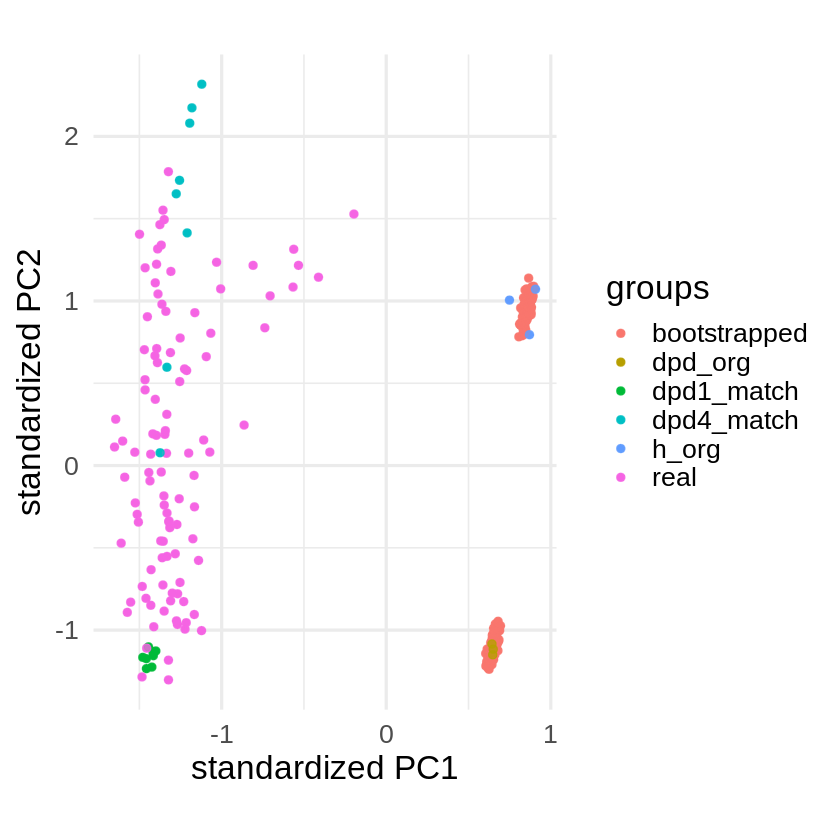

In [14]:
#########################################
### Create tags for PCA visualization ###
#########################################

# semi-matched bulk samples of the non-affected and affected groups 
# are tagged with "dpd4_match" and "dpd1_match" respectively
tags <- c()
for (col in colnames(bulk_data)){
    if (grepl("DPD1_brain_", col, fixed = TRUE)){
        tags <- c(tags, "dpd1_match")
    }else if (grepl("DPD4_brain_", col, fixed = TRUE)){
        tags <- c(tags, "dpd4_match")
    }else if (grepl("_bs", col, fixed = TRUE)){
        tags <- c(tags, "bootstrapped")
    }else if (grepl("org", col, fixed = TRUE) & grepl("h", col, fixed = TRUE)){
        tags <- c(tags, "h_org")
    }else if (grepl("org", col, fixed = TRUE) & grepl("dpd", col, fixed = TRUE)){
        tags <- c(tags, "dpd_org")
    }else{
        tags <- c(tags, "real")
    }
}

# do pca for real bulk, bootstrapped qc bulk and qc organoid bulk
bulk_data.pca <- prcomp(t(bulk_data), center = TRUE, scale = TRUE)

# plotting:
# http://agroninfotech.blogspot.com/2020/06/biplot-for-principal-component-analysis.html#add-main-and-legend-title
# https://www.tidyverse.org/blog/2020/08/taking-control-of-plot-scaling/
biplot= ggbiplot(bulk_data.pca, var.axes = F, groups= tags, ellipse= FALSE)
biplot= biplot + theme_minimal(base_size = 20) # to set the plot size 
biplot= biplot + geom_point(aes(color = groups), size = 2, alpha = 0.8) # to configure the points properties
biplot= biplot + labs(x= "standardized PC1", y= "standardized PC2")
print(biplot)
# save to disk
ggsave("./figures/bulk_realbsorg_pca.pdf", biplot, device= "pdf")

### Batch Effect Removal:

* rpkm normalize the real bulk data
* separate real bulk data into healthy and dpd (bulk_real_h, bulk_real_dpd)
* rpkm normalize the bs_h and bs_h (bulk_bs_h, bulk_bs_dpd)
* remove the genes with more than 20% zeros in all bulk datasets
* do bacth correction per group (affected, non-affected)

In [15]:
# rpkm-normalize the real bulk
# split the real bulk into affected and non-affected (healthy)
# remove genes with >20% zeros for each group

bulk_real_norm <- rpkm_normalize(bulk_real)
dpd_samples= c(grep(c("DPD1"), colnames(bulk_real), fixed= TRUE), grep("DPD3", colnames(bulk_real), fixed=TRUE), grep("DPD6", colnames(bulk_real), fixed=TRUE))
h_samples= c(grep("DPD2", colnames(bulk_real), fixed=TRUE), grep("DPD4", colnames(bulk_real), fixed=TRUE))
bulk_real_h= bulk_real_norm[, h_samples]
bulk_real_dpd= bulk_real_norm[, dpd_samples]
# remove genes with >20% zeros
bulk_real_h <- bulk_real_h[rowSums(bulk_real_h > 0) >= 0.8*dim(bulk_real_h)[2], ]
bulk_real_dpd <- bulk_real_dpd[rowSums(bulk_real_dpd > 0) >= 0.8*dim(bulk_real_dpd)[2], ]

# take the common genes
inter <- intersect(rownames(bulk_real_h), rownames(bulk_real_dpd))
bulk_real_h <- bulk_real_h[inter, ]
bulk_real_dpd <- bulk_real_dpd[inter, ]

bulk_real_comb <- do.call(cbind, list(bulk_real_dpd, bulk_real_h))

In [16]:
# rpkm-normalize the bootstrapped bulk (cells after QC are used)
# remove genes with >20% zeros per individual

bulk_bs_h <- rpkm_normalize(mix_bs$h)
bulk_bs_dpd <- rpkm_normalize(mix_bs$dpd)
# remove genes with >20% zeros
bulk_bs_h <- bulk_bs_h[rowSums(bulk_bs_h > 0) >= 0.8*dim(bulk_bs_h)[2], ]
bulk_bs_dpd <- bulk_bs_dpd[rowSums(bulk_bs_dpd > 0) >= 0.8*dim(bulk_bs_dpd)[2], ]

# take the common genes
inter <- intersect(rownames(bulk_bs_h), rownames(bulk_bs_dpd))
bulk_bs_h <- bulk_bs_h[inter, ]
bulk_bs_dpd <- bulk_bs_dpd[inter, ]

# bulk_bs for both individuals after gene removal 
bulk_bs_comb <- do.call(cbind, list(bulk_bs_dpd, bulk_bs_h))

In [17]:
# intersect the real bulk genes and bs bulk genes
comm_genes <- intersect(rownames(bulk_real_comb), rownames(bulk_bs_comb))
bulk_real_comb <- bulk_real_comb[comm_genes, ]
bulk_real_h <- bulk_real_h[comm_genes, ]
bulk_real_dpd <- bulk_real_dpd[comm_genes, ]

bulk_bs_comb <- bulk_bs_comb[comm_genes, ]
bulk_bs_h <- bulk_bs_h[comm_genes, ]
bulk_bs_dpd <- bulk_bs_dpd[comm_genes, ]

### Batch correction for each group (affected, non-affected) separately

Using batch =dpd_bsas a reference batch (this batch won't change)

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


Saving 6.67 x 6.67 in image
Using batch =h_bsas a reference batch (this batch won't change)

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




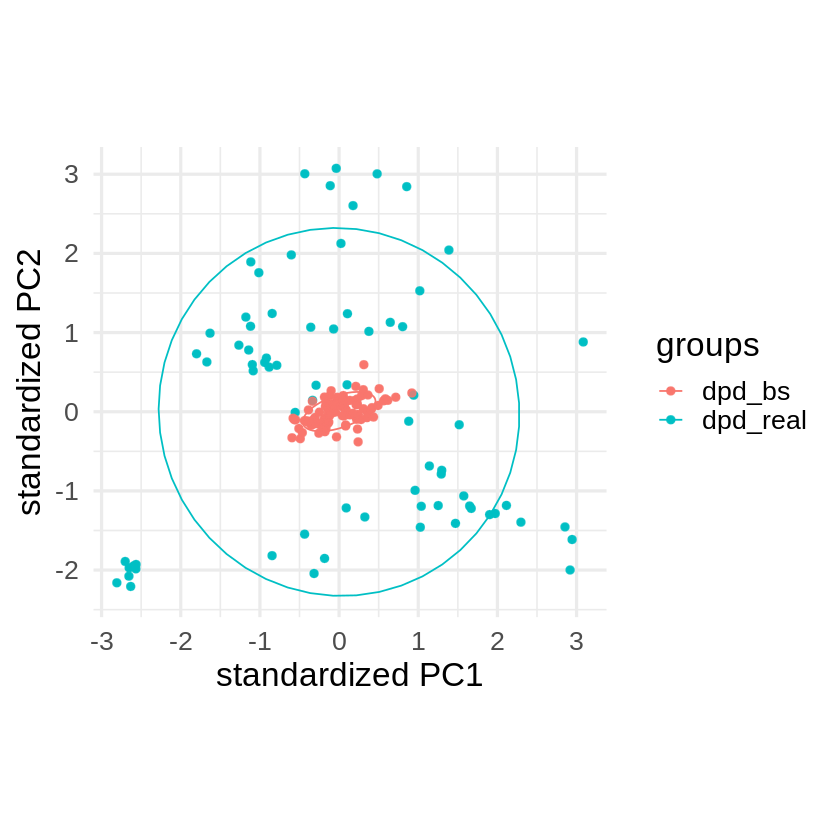

Saving 6.67 x 6.67 in image


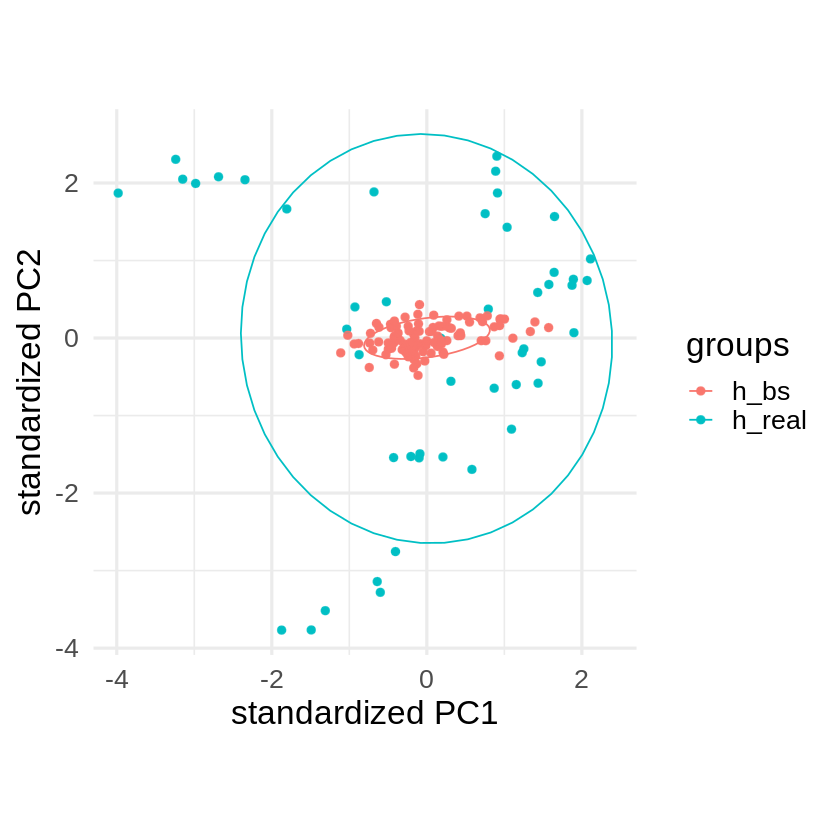

In [18]:
##################################################
### Batch correction for each group separately ###
###  Visualizing the batch corrected bulk and  ###
###   bootstrapped bulk samples (Figure S23B)  ###
##################################################

# dpd
dpd_data <- do.call(cbind, list(bulk_real_dpd, bulk_bs_dpd))
tags <- c(rep("dpd_real", dim(bulk_real_dpd)[2]), rep("dpd_bs", dim(bulk_bs_dpd)[2]))
dpd_data= log1p(dpd_data)
dpd_data_corr= ComBat(dat= dpd_data, batch=tags, ref.batch= "dpd_bs", mod=NULL, par.prior=TRUE, prior.plots=FALSE) # paremetric
dpd_data_corr <- exp(dpd_data_corr)-1
# pca after batch correction
#tags[1:8]= "dpd_matched"
dpd_data_corr.pca <- prcomp(t(dpd_data_corr), center = TRUE, scale = TRUE)
biplot= ggbiplot(dpd_data_corr.pca, var.axes = F, groups= tags, ellipse= TRUE)
biplot= biplot + theme_minimal(base_size = 20) # to set the plot size 
biplot= biplot + geom_point(aes(color = groups), size = 2, alpha = 0.8) # to configure the points properties
biplot= biplot + labs(x= "standardized PC1", y= "standardized PC2")
print(biplot)
ggsave("./figures/bulk_dpdbcorr_pca.pdf", biplot, device= "pdf")

# healthy
h_data <- do.call(cbind, list(bulk_real_h, bulk_bs_h))
tags <- c(rep("h_real", dim(bulk_real_h)[2]), rep("h_bs", dim(bulk_bs_h)[2]))
h_data= log1p(h_data)
h_data_corr= ComBat(dat= h_data, batch=tags, ref.batch= "h_bs", mod=NULL, par.prior=TRUE, prior.plots=FALSE) # paremetric
h_data_corr <- exp(h_data_corr)-1
# pca after batch correction
h_data_corr.pca <- prcomp(t(h_data_corr), center = TRUE, scale = TRUE)
biplot= ggbiplot(h_data_corr.pca, var.axes = F, groups= tags, ellipse= TRUE)
biplot= biplot + theme_minimal(base_size = 20) # to set the plot size 
biplot= biplot + geom_point(aes(color = groups), size = 2, alpha = 0.8) # to configure the points properties
biplot= biplot + labs(x= "standardized PC1", y= "standardized PC2")
print(biplot)
ggsave("./figures/bulk_hbcorr_pca.pdf", biplot, device= "pdf")

### Save the batch-corrected real bulk data

In [19]:
# save the batch corrected real bulk data
savedir= "dpd_results/bulk_preprocess"
dir.create(savedir, recursive= TRUE, showWarnings = FALSE)

# subset individual batch corrected data to real bulk samples
dpd_data_real_corr <- dpd_data_corr[, 1:dim(bulk_real_dpd)[2]]
h_data_real_corr <- h_data_corr[, 1:dim(bulk_real_h)[2]]

# add EnsID column
add_ensid <- function(T){
    T$EnsID <- rownames(T)
    T <- T[,c(ncol(T),1:(ncol(T)-1))]
    T <- T[order(T$EnsID),]
    return(T)
}
dpd_data_real_corr <- add_ensid(as.data.frame(dpd_data_real_corr))
h_data_real_corr <- add_ensid(as.data.frame(h_data_real_corr))

write.table(dpd_data_real_corr , file = paste0(savedir, "/dpd_affected"), sep = "\t", quote = FALSE, row.names = FALSE, col.names= TRUE)
write.table(h_data_real_corr , file = paste0(savedir, "/dpd_healthy"), sep = "\t", quote = FALSE, row.names = FALSE, col.names= TRUE)

### Save the bootstrapped+organoid bulk samples for each individual

In [20]:
# intersect the genes for organoid and bs samples
# concatenate the bs and organoid dataframes
# add rownames to the props for bs and organoid

bulk_org_props_dpd <- bulk_org_props[grep("dpd", rownames(bulk_org_props)), ]
bulk_org_props_h <- bulk_org_props[grep("h", rownames(bulk_org_props)), ]

# dpd
inter <- intersect(rownames(bulk_bs_dpd), rownames(bulk_org))
bulk_bs_dpd <- bulk_bs_dpd[inter, ]
bulk_org <- bulk_org[inter, ]
bulk_org_dpd <- bulk_org[, grep("dpd", colnames(bulk_org))]
bulk_org_dpd <- rpkm_normalize(bulk_org_dpd)
bulk_bs_dpd_all <- cbind(bulk_org_dpd, bulk_bs_dpd)
bulk_bs_dpd_all <- add_ensid(as.data.frame(bulk_bs_dpd_all))

# merge proportions
prop_bs_dpd_all <- rbind.fill(bulk_org_props_dpd, prop_bs$dpd) # drops the rownames
rownames(prop_bs_dpd_all) <- c(rownames(bulk_org_props_dpd), colnames(bulk_bs_dpd))


# healthy
inter <- intersect(rownames(bulk_bs_h), rownames(bulk_org)) # extra as bulk_bs_h and bulk_bs_dpd have the same genes
bulk_bs_h <- bulk_bs_h[inter, ]
bulk_org <- bulk_org[inter, ]
bulk_org_h <- bulk_org[, grep("h", colnames(bulk_org))]
bulk_org_h <- rpkm_normalize(bulk_org_h)
bulk_bs_h_all <- cbind(bulk_org_h, bulk_bs_h)
bulk_bs_h_all <- add_ensid(as.data.frame(bulk_bs_h_all))

# merge proportions
prop_bs_h_all <- rbind.fill(bulk_org_props_h, prop_bs$h) # drops the rownames
rownames(prop_bs_h_all) <- c(rownames(bulk_org_props_h), colnames(bulk_bs_h))

In [21]:
write.table(bulk_bs_dpd_all , file = paste0(savedir, "/dpd_bulk_bs"), sep = "\t", quote = FALSE, row.names = FALSE, col.names= TRUE)
write.table(bulk_bs_h_all , file = paste0(savedir, "/h_bulk_bs"), sep = "\t", quote = FALSE, row.names = FALSE, col.names= TRUE)

write.table(prop_bs_dpd_all , file = paste0(savedir, "/dpd_prop_bs"), sep = "\t", quote = FALSE, row.names = TRUE, col.names= TRUE)
write.table(prop_bs_h_all , file = paste0(savedir, "/h_prop_bs"), sep = "\t", quote = FALSE, row.names = TRUE, col.names= TRUE)

In [22]:
# save the real bulk data after rpkm-normalization and gene removal (80%)
bulk_real_dpd_proc <- add_ensid(as.data.frame(bulk_real_dpd))
bulk_real_h_proc <- add_ensid(as.data.frame(bulk_real_h))
write.table(bulk_real_dpd_proc , file = paste0(savedir, "/dpd_bulk_real_notBC"), sep = "\t", quote = FALSE, row.names = FALSE, col.names= TRUE)
write.table(bulk_real_h_proc , file = paste0(savedir, "/h_bulk_real_notBC"), sep = "\t", quote = FALSE, row.names = FALSE, col.names= TRUE)